In [476]:
import numpy as np 
import pandas as pd
cust_churn = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
from math import isnan 

#setting up the data and cleaning 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

#model to use 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC

# measure the score of the model 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

# Dont inlcude the customer ID as may cause leakage later on down the line
cust_churn = cust_churn.iloc[:,1:]

# Turn the total charges into a numeric data type with nan for the unreadable columns 
cust_churn['TotalCharges'] = pd.to_numeric(cust_churn['TotalCharges'],errors = 'coerce')

#remove the nan values from the dataset 
# drop na results so both columns the same lentgh 
cut_churn = cust_churn[['TotalCharges','tenure']].dropna()

#Turn the y values into a binary output
#Turn churn into an integer binary value
for i in range(0,len(cust_churn['Churn'])):
    if cust_churn['Churn'].iloc[i] == 'No':
        cust_churn['Churn'].iloc[i] = 0
    else:
        cust_churn['Churn'].iloc[i] = 1

#Turns churn into a numeric data type so the model can use it 
cust_churn['Churn'] = pd.to_numeric(cust_churn['Churn'])

        
#try by dropping non needed values 
#produces worse pecision and recall than y = mx + c method
#cust_churn = cust_churn.dropna()

# find y = mx + c and use to find the mising values with highly correlated columns 
mb = np.polyfit(cut_churn['tenure'],cut_churn['TotalCharges'], 1)
for i in range(0,len(cust_churn)):
    if isnan(cust_churn['TotalCharges'].iloc[i]):
        cust_churn['TotalCharges'].iloc[i] = mb[0] * cust_churn['tenure'].iloc[i] + mb[1]
        print('row:', i)


In [559]:
cust_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


In [560]:
#expolre object data ad check one hot encoding wont produce to many columns and if there is any NA values 
cust_churn['TotalCharges'].drop_duplicates()
#total charges will need to be changed to a numeric data type 

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 6530, dtype: float64

In [563]:
# find the correlation to see if any can be matched to the other 
cust_churn[(cust_churn.select_dtypes(include = ['float64','int64']).columns)].corr()
# tenure has the highest correlation so replace nan values with 

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000000,0.015683,0.219874,0.102411,0.150541
tenure,0.015683,1.000000,0.246862,0.825880,-0.354049
MonthlyCharges,0.219874,0.246862,1.000000,0.651065,0.192858
TotalCharges,0.102411,0.825880,0.651065,1.000000,-0.199484
Churn,0.150541,-0.354049,0.192858,-0.199484,1.000000


In [147]:
############################# bulding the model pipeline #######################

In [478]:
#X and y created from data sets 
#The customer id if 
X = cust_churn.iloc[:,0:-1]
y = cust_churn.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [565]:
#try one hot encoder on the x to see why it is giving bad values 
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
pd.DataFrame(OH_encoder.fit_transform(cust_churn.select_dtypes(include = 'object')))
#Correct number of inputs 

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7028,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7029,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7030,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [479]:
#Check to see if any of the object columns have a large number of values that OHE wont handle 
for i in range(0,len(cust_churn.select_dtypes(include = 'object').columns)):
    print(cust_churn.select_dtypes(include = 'object').columns[i],':',len(cust_churn.select_dtypes(include = 'object').iloc[:,i].drop_duplicates()))

gender : 2
Partner : 2
Dependents : 2
PhoneService : 2
MultipleLines : 3
InternetService : 3
OnlineSecurity : 3
OnlineBackup : 3
DeviceProtection : 3
TechSupport : 3
StreamingTV : 3
StreamingMovies : 3
Contract : 3
PaperlessBilling : 2
PaymentMethod : 4


In [480]:
#Find the categorical columns to one hot encode
categorical_cols = X.select_dtypes(include = 'object').columns
# create the piplen for each model to is can be used each time when processing the data.
ohe_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe_pipeline, categorical_cols)
    ])

In [567]:
# find the number of branches needed to minimize the error 
# no emphasise on high precision or recall so f1 score used to get both 
#63 appears to be the best 
for i in (2,58,59,60,61,62,63,64):
    RFC = RandomForestClassifier(random_state = 0,n_estimators = i)
    RFC_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                              ('model', RFC)])
    RFC_pipeline.fit(X_train,y_train)
    y_pred = RFC_pipeline.predict(X_test)
    print(f1_score(y_test,y_pred))

0.4714003944773176
0.5150943396226415
0.5169172932330827
0.5193578847969783
0.5192850423330198
0.5165562913907286
0.5203405865657521
0.5193578847969783


In [566]:
#C = 1 has the highest f1 score appears to be the best the same method 
Log = LogisticRegression(random_state = 0)
Log_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                         ('model', Log)])
Log_pipeline.fit(X_train,y_train)
y_pred_log = Log_pipeline.predict(X_test)
#print(f1_score(y_test,y_pred))
print(f1_score(y_test,y_pred_log))

0.5591397849462365


In [438]:
#all degrees of polynomial function produced the same result so 1 was used. Most likely due to the small size of the data set 
#No change  in ovo or ovr
for i in ('ovr','ovo'):
    SVC_mod = SVC(random_state = 0,decision_function_shape = i)
    SVC_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                              ('model', SVC_mod)])
    SVC_pipeline.fit(X_train,y_train)
    y_pred = SVC_pipeline.predict(X_test)
    print(f1_score(y_test,y_pred))

0.5611192930780559
0.5611192930780559


In [568]:
import random 
#Check if score is better than random guessing y_test
for i in range(0,5):
    rnd_set = []
    for i in range(0,len(y_test)):
        if random.uniform(0, 1) < (y_test.sum()/len(y_test)):
            rnd_set.append(1)
        else:
            rnd_set.append(0)

    print(f1_score(rnd_set,y_pred))

0.24975984630163303
0.24112149532710278
0.23282442748091603
0.23716153127917833
0.23062730627306272


In [414]:
#value is better than random guessing for the models that are used
#higher precision preferred if incentive for customer stay on is expensive but vice versa for recall
#Logistic regression produced the best result overall 
#cross validation not used due to the small sample size 

In [569]:
#Find the atributions of the model that cause the greatest change when not included 
atb_values = {}

for i in X.columns:
    tot = 0
    X_train_drop_cols = X_train.columns.tolist()
    X_train_drop_cols.remove(i)
    
    categorical_cols = X[X_train_drop_cols].select_dtypes(include = 'object').columns
    
    ohe_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
    transformers=[('cat', ohe_pipeline, categorical_cols)
    ])
    
    Log = LogisticRegression(random_state = 0)
    Log_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                         ('model', Log)])
    
    #print(X_train_drop_cols)
    #print(X_test[X_train_drop_cols])
    Log_pipeline.fit(X_train[X_train_drop_cols],y_train)
    y_pred = Log_pipeline.predict(X_test[X_train_drop_cols])
    tot += f1_score(y_test,y_pred)
    atb_values[i] = tot
    
    

<BarContainer object of 19 artists>

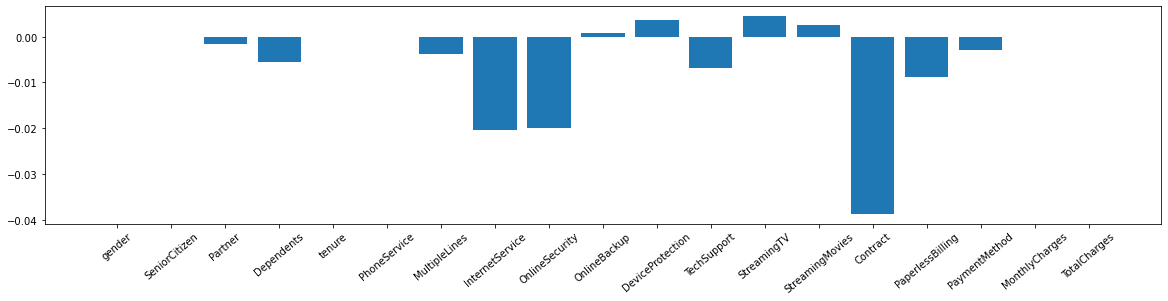

In [570]:
#Greatest drop from contract not being included showing it was one of the greatest
#determining factors in finding the probability of churn 
import matplotlib.pyplot as plt
keys = atb_values.keys()
values = list(atb_values.values())
for i in range(0,len(values)):
    values[i] = values[i] - f1_score(y_test,y_pred_log) # take off the f1 score of previous to see how much each one drops 
plt.figure(figsize=(20,4))
plt.xticks(rotation=40)
plt.bar(keys, values)
